In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import glob
import itertools
import os
import random
from os import listdir
from os.path import isfile, join

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow.keras.backend as K
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, Input,
    LeakyReLU, MaxPool2D, SeparableConv2D)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Путь к директории
PATH = 'C:/Users/dmtry/Desktop/OCT2017'

In [4]:
# Пути к тестовой и обучающей папкам
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

In [5]:
batch_size = 64
epochs = 15
# Размер изображения
IMG_HEIGHT = 227
IMG_WIDTH = 227
model_name = '4 layers'

## Инициализация генераторов

In [6]:
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')  
test_image_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           color_mode='grayscale',
                                                           class_mode='sparse',
                                                           subset = 'training')
print()
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory = train_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode='grayscale',
                                                              class_mode='sparse',
                                                              subset = 'validation')
print()
test_data_gen = test_image_generator.flow_from_directory(batch_size = 1,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              color_mode='grayscale',
                                                              class_mode='sparse')

Found 66788 images belonging to 4 classes.

Found 16696 images belonging to 4 classes.

Found 968 images belonging to 4 classes.


## Создание модели

In [8]:
model = Sequential()
#==============================================================================================================
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers. Dropout(0.25)) 
#==============================================================================================================
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers. Dropout(0.25))
#==============================================================================================================
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers. Dropout(0.25)) 
#==============================================================================================================
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers. Dropout(0.25)) 
#==============================================================================================================
model.add(layers.Flatten()) 
#==============================================================================================================
model.add(layers.Dense(128, activation='relu')) 
model.add(layers. Dropout(0.3))
#==============================================================================================================
model.add(layers.Dense(64, activation='relu')) 
#==============================================================================================================
model.add(layers.Dense(4, activation='softmax'))

## Применение обратных вызовов для контроля обучения

In [9]:
callbacks_list = [ tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1,verbose = 1),
tf.keras.callbacks.ModelCheckpoint( filepath = 'C:/Users/dmtry/Desktop/MODELS/' + model_name + '.h5', monitor='val_accuracy',save_best_only=True, mode = 'max', verbose = 1),
tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience = 2, verbose = 1)]

## Применение нормализации весов

In [10]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_data_gen.classes),
                                                  train_data_gen.classes)

## Компиляция модели

In [11]:
model.compile(optimizer = 'rmsprop', loss ='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 227, 227, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 113, 113, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 113, 113, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 128)       7

## Обучение

In [13]:
hist = model.fit_generator(
    train_data_gen,
    steps_per_epoch = train_data_gen.samples // batch_size,
    epochs = epochs,
    validation_data = val_data_gen,
    validation_steps= val_data_gen.samples // batch_size,
    class_weight=class_weights,
    callbacks = callbacks_list)

Epoch 1/15
1042/1043 [============================>.] - ETA: 0s - loss: 0.9545 - accuracy: 0.6302
Epoch 00001: val_accuracy improved from -inf to 0.70090, saving model to C:/Users/dmtry/Desktop/MODELS/4 layers.h5
1043/1043 [==============================] - 843s 808ms/step - loss: 0.9544 - accuracy: 0.6302 - val_loss: 0.8505 - val_accuracy: 0.7009
Epoch 2/15
1042/1043 [============================>.] - ETA: 0s - loss: 0.6872 - accuracy: 0.7477
Epoch 00002: val_accuracy improved from 0.70090 to 0.78137, saving model to C:/Users/dmtry/Desktop/MODELS/4 layers.h5
1043/1043 [==============================] - 663s 635ms/step - loss: 0.6872 - accuracy: 0.7477 - val_loss: 0.6220 - val_accuracy: 0.7814
Epoch 3/15
1042/1043 [============================>.] - ETA: 0s - loss: 0.5460 - accuracy: 0.8049
Epoch 00003: val_accuracy improved from 0.78137 to 0.78954, saving model to C:/Users/dmtry/Desktop/MODELS/4 layers.h5
1043/1043 [==============================] - 515s 494ms/step - loss: 0.5461 - acc

# Графики

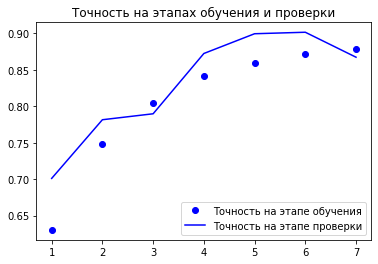

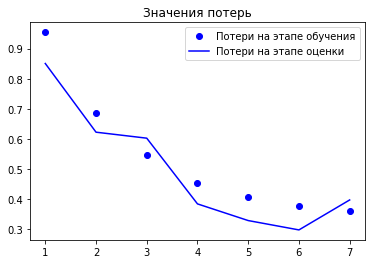

In [14]:
acc = hist.history['accuracy'] 
val_acc = hist.history['val_accuracy'] 
loss = hist.history['loss'] 
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1) 
plt.plot(epochs, acc, 'bo', label = 'Точность на этапе обучения') 
plt.plot(epochs, val_acc, 'b', label = 'Точность на этапе проверки') 
plt.title('Точность на этапах обучения и проверки') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Потери на этапе обучения') 
plt.plot(epochs, val_loss, 'b', label='Потери на этапе оценки') 
plt.title('Значения потерь') 
plt.legend()
plt.show()

In [8]:
model = tf.keras.models.load_model('C:\\Users\\dmtry\\Desktop\\MODELS\\4 layers.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# Оценка

In [9]:
label_map = (train_data_gen.class_indices)
print(label_map)

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [10]:
model.evaluate_generator(test_data_gen, verbose = 1)

968/968 [==============================] - 67s 69ms/step - loss: 0.1699 - accuracy: 0.9452


[0.16985213554556153, 0.94524795]

## Матрица неточностей

In [9]:
test_data_gen.reset()
y_pred = model.predict_generator(test_data_gen,steps = 968)
Y_test = test_data_gen.classes[test_data_gen.index_array]
Y_pred = np.argmax(y_pred, axis=-1)

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

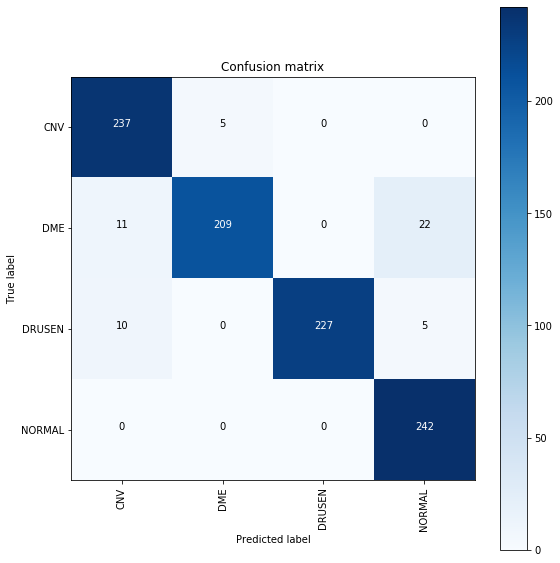

In [17]:
cm = confusion_matrix(Y_test, Y_pred)
 
plt.figure(figsize=(8,8))
plt.grid(b=False)
plot_confusion_matrix(cm, classes=['CNV','DME','DRUSEN','NORMAL'], normalize=False, 
                      title='Confusion matrix', cmap = plt.cm.Blues)
plt.show()

## Чувствительность, специфичность, F1

In [10]:
from sklearn.metrics import classification_report
print(classification_report(Y_test,Y_pred,target_names=['CNV','DME','DRUSEN','Normal']))

precision    recall  f1-score   support

         CNV       0.92      0.98      0.95       242
         DME       0.98      0.86      0.92       242
      DRUSEN       1.00      0.94      0.97       242
      Normal       0.90      1.00      0.95       242

    accuracy                           0.95       968
   macro avg       0.95      0.95      0.94       968
weighted avg       0.95      0.95      0.94       968



# Карты активации

Исходное изображение 



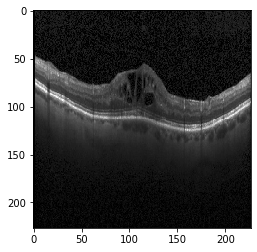

In [10]:
img_path = 'C:\\Users\\dmtry\\Desktop\\OCT2017\\test\\DME\\DME-30521-3.jpeg'

img = image.load_img(img_path, grayscale = True, target_size=(IMG_HEIGHT, IMG_WIDTH)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis=0) 
img_tensor /= 255

plt.imshow(img_tensor.reshape(227,227), cmap = 'gray') 
print('Исходное изображение','\n')
plt.show()

In [11]:
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]

print('Размер карты активации: ' + str(first_layer_activation.shape)) 

Размер карты активации: (1, 227, 227, 32)


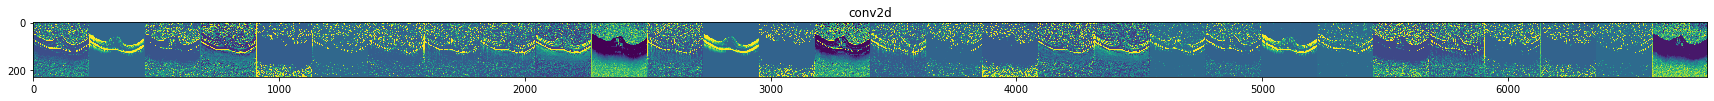

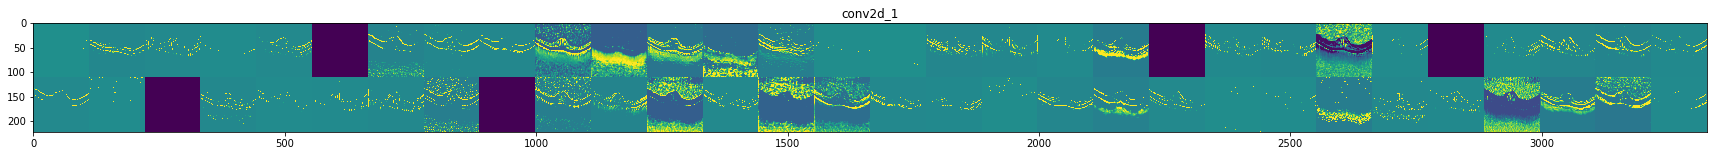

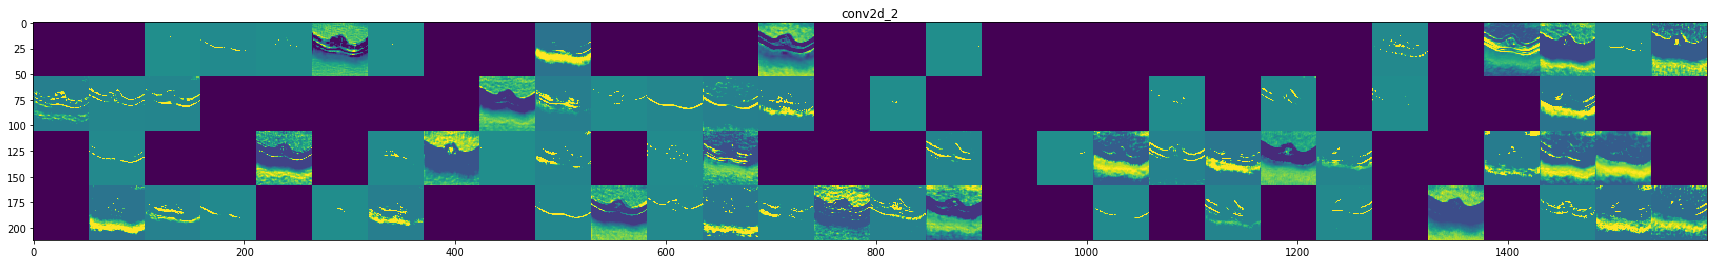

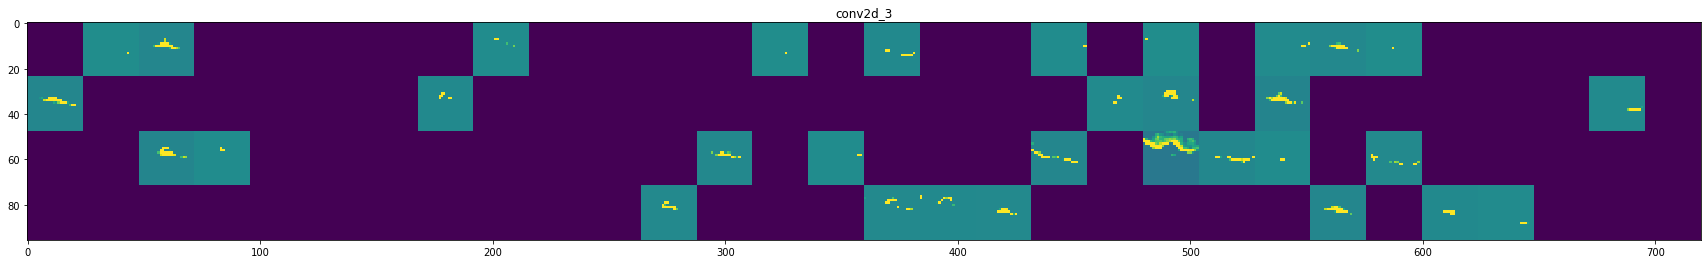

In [12]:
layer_names = [] 
for layer in model.layers:
    if 'conv' in layer.name:
        layer_names.append(layer.name)
images_per_row = 30 
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row     
    display_grid = np.zeros((size * n_cols, images_per_row * size))
 
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]            
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size    
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Тепловая карта активации

Класс:  DME 

Тепловая карта активации: 



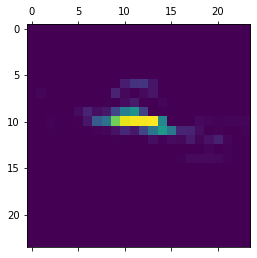

In [13]:
preds = model.predict(img_tensor)

np.argmax(preds[0])

label_map = (train_data_gen.class_indices)

for i,j in label_map.items():
    if j == np.argmax(preds[0]):
        class_name = i
        print('Класс: ',i,'\n')

drus = model.output[:,np.argmax(preds[0])]

last_conv_layer = model.get_layer(layer_names[-1])

grads = K.gradients(drus,last_conv_layer.output)[0]

pooled_grads = K.mean(grads, axis=(0, 1, 2)) 

iterate = K.function([model.input],[pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

heatmap = np.maximum(heatmap, 0) 
heatmap /= np.max(heatmap) 
print('Тепловая карта активации:','\n')
plt.matshow(heatmap)

In [15]:
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('C:/Users/dmtry/Desktop/MODELS/' + model_name + str(class_name) + '.jpg', superimposed_img)

True

## Наложенные карты активации

<img src="4 layers.jpg">